In [1]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
import os
import re
import time
import math
from matplotlib import pyplot as plt
from collections import defaultdict
from itertools import combinations
import networkx as nx
from scipy.stats import pearsonr
from concurrent.futures import ProcessPoolExecutor
import ast

## Create Layer 1

In [2]:
import networkx as nx
import ast

def create_layer1_threshold(edges_dict, k_value, undirected=False):
    """
    Create a network layer by filtering edges based on a threshold and normalizing weights using min-max normalization.

    Args:
        edges_dict (dict): Dictionary containing edge data, where keys are edge tuples (as strings)
                           and values are dictionaries with weight data.
        threshold (float): Threshold for including edges in the graph.
        undirected (bool): Whether the graph is undirected or directed.

    Returns:
        nx.Graph or nx.DiGraph: A graph object containing edges that pass the threshold.
    """
    # Step 1: Extract all weights to find min and max values
    if undirected:
        weights = [edge_data['simmetric_weight'] for edge_data in edges_dict.values()]
    else:
        weights = [
            weight 
            for edge_data in edges_dict.values() 
            for weight in (edge_data['weight_user1'], edge_data['weight_user2'])
        ]
    threshold = np.percentile(np.array(weights), k_value)
    # Compute min and max weights for normalization
    w_min = min(weights)
    w_max = max(weights)

    # Avoid division by zero in case all weights are the same
    if w_max == w_min:
        normalize = lambda w: 1.0  # Set all normalized weights to 1.0
    else:
        normalize = lambda w: (w - w_min) / (w_max - w_min)  # Min-max normalization

    threshold = (threshold -w_min) / (w_max - w_min)
    # Step 2: Create the graph
    if undirected:
        G = nx.Graph()
        for edge, edge_data in edges_dict.items():
            e = ast.literal_eval(edge)
            normalized_weight = normalize(edge_data['simmetric_weight'])
            if normalized_weight > threshold:
                G.add_edge(e[0], e[1], weight=normalized_weight)
    else:
        G = nx.DiGraph()
        for edge, edge_data in edges_dict.items():
            e = ast.literal_eval(edge)
            normalized_weight_user1 = normalize(edge_data['weight_user1'])
            normalized_weight_user2 = normalize(edge_data['weight_user2'])
            if normalized_weight_user1 > threshold:
                G.add_edge(e[0], e[1], weight=normalized_weight_user1)
            if normalized_weight_user2 > threshold:
                G.add_edge(e[1], e[0], weight=normalized_weight_user2)

    return G


def get_percentile(edges, k_value):
    weights = []
    for edge, edge_dict in edges.items():
        weights.append(edge_dict['simmetric_weight'])
    return np.percentile(np.array(weights), k_value)

In [3]:
file_path = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edges_dict_weight.json'
with open(file_path, "r") as json_file:
    edges_dict = json.load(json_file)

In [4]:
layer1 = create_layer1_threshold(edges_dict, 90, undirected=True)

## Create Layer 2

In [5]:
def calculate_similarity_index2(users_items, item_rarity, item_collections, alpha=0.5, collection_rarity=None):
    """
    Calculates edge weights (similarity indices) between user pairs with normalization
    and dynamic threshold adjustment.
    
    Args:
        users_items (dict): Maps users to their collectible items.
        item_rarity (dict): Maps items to their rarity (lower = rarer).
        item_collections (dict): Maps items to their collections.
        alpha (float): Weight for collection-based similarity (default: 0.5).
        collection_rarity (dict): Maps collections to their rarity (optional).
    
    Returns:
        list: List of tuples (user1, user2, normalized weight).
    """
    edges = []

    # Find all user pairs
    user_pairs = combinations(users_items.keys(), 2)

    for user1, user2 in user_pairs:
        # Get the items of each user
        items1 = set(users_items[user1])
        items2 = set(users_items[user2])

        if not items1 or not items2:
            continue

        # Compute shared items and collections
        common_items = items1.intersection(items2)
        collections1 = {item_collections[item] for item in items1}
        collections2 = {item_collections[item] for item in items2}
        common_collections = collections1.intersection(collections2)

        if not common_items and not common_collections:
            continue

        # Compute item rarity-based weight
        weight_rarity = sum(1 / item_rarity[item] for item in common_items)

        # Compute collection similarity weight
        if collection_rarity:
            weight_collections = sum(1 / collection_rarity[collection] for collection in common_collections)
        else:
            weight_collections = len(common_collections)

        # Calculate raw similarity index
        raw_weight = weight_rarity + alpha * weight_collections

        # Normalize weight
        max_possible_rarity = sum(1 / item_rarity[item] for item in items1.union(items2))
        max_possible_collections = len(collections1.union(collections2)) if not collection_rarity else \
                                   sum(1 / collection_rarity[collection] for collection in collections1.union(collections2))
        max_possible_weight = max_possible_rarity + alpha * max_possible_collections
        normalized_weight = raw_weight / max_possible_weight

        # Dynamic threshold adjustment
        threshold = 0.0  # Example threshold scaling
        if normalized_weight >= threshold:
            edges.append((user1, user2, normalized_weight))

    return edges


def compute_edges2(all_wearables, alpha=0.5, wearable_to_collection=None):
    """
    Computes edges with normalized weights and dynamic threshold adjustment between users.
    
    Args:
        all_wearables (dict): Maps users to their wearables.
        alpha (float): Weight for collection-based similarity (default: 0.5).
    
    Returns:
        list: List of edges (user1, user2, normalized weight).
    """
    users_items = {}
    item_rarity = {}
    item_collections = {}
    collection_rarity = {}

    # Populate users_items, item_rarity, and item_collections
    for user, wearables in all_wearables.items():
        users_items[user] = []
        for wearable in wearables:
            nft_name = wearable['nft_name']
            if wearable_to_collection:
                nft_collection = wearable_to_collection[nft_name]
            else:
                nft_collection = wearable['nft_collection']

            item_rarity[nft_name] = item_rarity.get(nft_name, 0) + 1
            collection_rarity[nft_collection] = collection_rarity.get(nft_collection, 0) + 1
            users_items[user].append(nft_name)
            item_collections[nft_name] = nft_collection

    # Compute edges with the new similarity function
    edges = calculate_similarity_index2(users_items, item_rarity, item_collections, alpha, collection_rarity)

    return edges


In [6]:
file_path = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/address_to_wearables.json'
with open(file_path, "r") as json_file:
    address_to_wearables = json.load(json_file)

In [7]:
k = 15
new_address_to_wearables = {}
num_wearables = []

for address, wearables in address_to_wearables.items():
    num_wearables.append(len(wearables))
    if len(wearables) < k:
        continue
    new_address_to_wearables[address] = wearables

In [8]:
alpha = 0.5

edges = compute_edges2(new_address_to_wearables, alpha)

In [9]:
# Get an array of weights
weights = []

for edge in edges:
    weights.append(edge[2])

weights = np.array(weights)

In [10]:
def create_layer2(edges, threshold):
    G = nx.Graph()
    for edge in edges:
        if edge[2] > threshold:
            G.add_edge(edge[0], edge[1], weight = edge[2]) 
    return G

threshold = np.percentile(weights, 90)
layer2 = create_layer2(edges, threshold)

## Create Layer 3

In [11]:
def contains_keyword(string, keywords):
    return any(keyword in string for keyword in keywords)

def create_edges(all_events, keywords):
    edges = []
    addresses = list(all_events.keys())
    for address, events in all_events.items():
        for event in events:
            nft_description = event.get('nft_description')

            if nft_description and "DCL Wearable" in nft_description:
                continue

            if event.get('nft_name') and contains_keyword(event.get('nft_name'), keywords):
                continue

            if event.get('from') == address and event.get('to') in addresses and event.get('to') != address:

                edges.append([address, event.get('to'), 1])
            if event.get('seller') == address and event.get('buyer') in addresses and event.get('buyer') != address:

                edges.append([address, event.get('buyer'), 1+event.get('price', 0)])

    return edges

In [12]:
file_path = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/address_to_events_final.json'
with open(file_path, "r") as json_file:
    address_to_events = json.load(json_file)

In [13]:
# Creating wearables windows for each address
keywords = ["decentraland", "dcl", "decentral", "wearable", "decentral-games", "parcel", "MANA", 'Decentraland']
edges = create_edges(address_to_events, keywords=keywords)

In [14]:
edges_dict = {}
for edge in edges:
    e = tuple(set(edge[0:2]))
    if e not in edges_dict.keys():
        edges_dict[e] = edge[2]
    else:
        edges_dict[e] += edge[2]

In [15]:
layer3 = nx.Graph()
for edge, weight in edges_dict.items():
    layer3.add_edge(edge[0], edge[1], weight=weight)

## Grpah

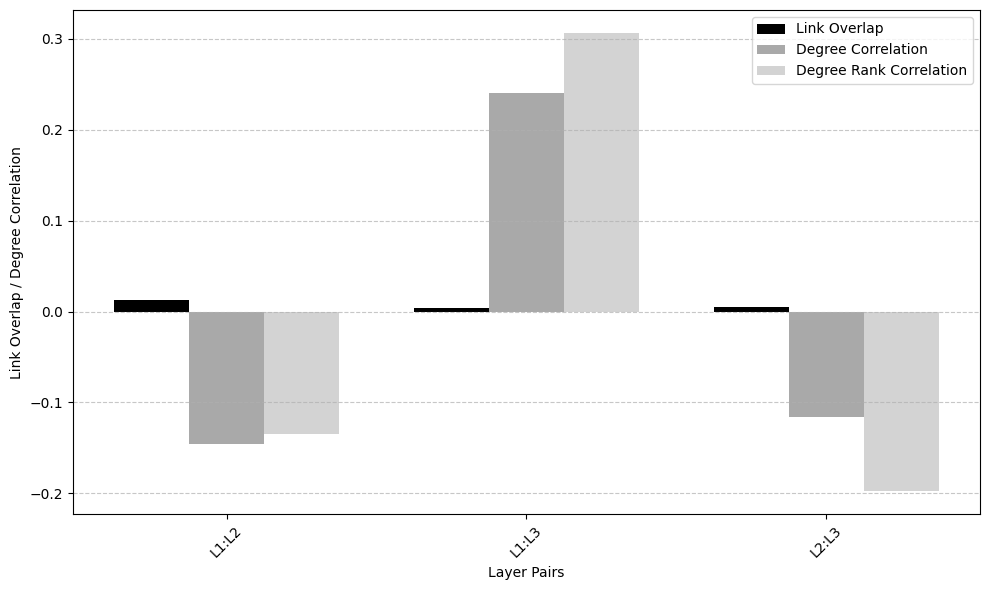

In [17]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import combinations

# Step 1: Create the Multilayer Network

# Combine into a multilayer network
layers = {"L1": layer1, "L2": layer2, "L3": layer3}

# Step 2: Define Metrics
def link_overlap(layer1, layer2):
    edges1 = set(layer1.edges())
    edges2 = set(layer2.edges())
    overlap = len(edges1 & edges2) / len(edges1 | edges2) if edges1 | edges2 else 0
    return overlap

def degree_correlation(layer1, layer2):
    degree1 = dict(layer1.degree())
    degree2 = dict(layer2.degree())
    common_nodes = set(degree1.keys()) & set(degree2.keys())
    degrees1 = np.array([degree1[node] for node in common_nodes])
    degrees2 = np.array([degree2[node] for node in common_nodes])
    correlation = np.corrcoef(degrees1, degrees2)[0, 1]
    return correlation

def degree_rank_correlation(layer1, layer2):
    degree1 = dict(layer1.degree())
    degree2 = dict(layer2.degree())
    common_nodes = set(degree1.keys()) & set(degree2.keys())
    degrees1 = np.array([degree1[node] for node in common_nodes])
    degrees2 = np.array([degree2[node] for node in common_nodes])
    rank_corr, _ = spearmanr(degrees1, degrees2)
    return rank_corr

# Step 3: Compute Metrics for All Layer Pairs
pairs = list(combinations(layers.keys(), 2))
overlap_values = []
degree_corr_values = []
rank_corr_values = []

for (l1, l2) in pairs:
    overlap_values.append(link_overlap(layers[l1], layers[l2]))
    degree_corr_values.append(degree_correlation(layers[l1], layers[l2]))
    rank_corr_values.append(degree_rank_correlation(layers[l1], layers[l2]))

# Step 4: Plot the Bar Chart
x_labels = [f"{p[0]}:{p[1]}" for p in pairs]
x = np.arange(len(x_labels))  # X positions
width = 0.25  # Width of the bars

plt.figure(figsize=(10, 6))

# Bar plots
plt.bar(x - width, overlap_values, width, label="Link Overlap", color="black")
plt.bar(x, degree_corr_values, width, label="Degree Correlation", color="darkgray")
plt.bar(x + width, rank_corr_values, width, label="Degree Rank Correlation", color="lightgray")

# Labels and Title
plt.xticks(x, x_labels, rotation=45)
plt.ylabel("Link Overlap / Degree Correlation")
plt.xlabel("Layer Pairs")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show Plot
plt.show()


## Metrics

In [20]:
import networkx as nx
from itertools import combinations
import numpy as np

def compute_multilayer_metrics(layers):
    """
    Compute metrics for a multilayer network.

    Parameters:
        layers (dict): A dictionary where keys are layer names (str) and values are NetworkX graphs.

    Returns:
        dict: A dictionary of computed metrics.
    """
    metrics = {}

    # Number of layers
    metrics['num_layers'] = len(layers)

    # Number of nodes and edges per layer
    metrics['nodes_per_layer'] = {layer: g.number_of_nodes() for layer, g in layers.items()}
    metrics['edges_per_layer'] = {layer: g.number_of_edges() for layer, g in layers.items()}

    # Total nodes and edges
    all_nodes = set().union(*[set(g.nodes) for g in layers.values()])
    all_edges = set().union(*[set(g.edges) for g in layers.values()])
    metrics['total_nodes'] = len(all_nodes)
    metrics['total_edges'] = len(all_edges)

    # Clustering coefficient per layer
    metrics['clustering_coeff_per_layer'] = {layer: nx.average_clustering(g) for layer, g in layers.items()}

    # Link overlap between layers (using min length of edge sets as denominator)
    metrics['link_overlap'] = {}
    for (layer1, g1), (layer2, g2) in combinations(layers.items(), 2):
        overlap = len(set(g1.edges).intersection(set(g2.edges)))
        min_length = min(len(set(g1.edges)), len(set(g2.edges)))
        metrics['link_overlap'][(layer1, layer2)] = overlap / min_length if min_length > 0 else 0

    # Link overlap and common nodes for all three layers
    edge_sets = [set(g.edges) for g in layers.values()]
    node_sets = [set(g.nodes) for g in layers.values()]
    overlap_all_layers = len(set.intersection(*edge_sets))
    min_edge_set_length = min(len(edge_set) for edge_set in edge_sets)
    metrics['link_overlap_all_layers'] = overlap_all_layers / min_edge_set_length if min_edge_set_length > 0 else 0
    metrics['common_nodes_all_layers'] = len(set.intersection(*node_sets))

    # Common nodes between layers
    metrics['common_nodes'] = {}
    for (layer1, g1), (layer2, g2) in combinations(layers.items(), 2):
        common = len(set(g1.nodes).intersection(set(g2.nodes)))
        metrics['common_nodes'][(layer1, layer2)] = common

    # Layer density
    metrics['density_per_layer'] = {layer: nx.density(g) for layer, g in layers.items()}

    # Node participation across layers
    metrics['node_participation'] = {node: sum(1 for g in layers.values() if node in g.nodes) for node in all_nodes}

    # Interlayer degree correlation
    metrics['interlayer_degree_corr'] = {}
    for (layer1, g1), (layer2, g2) in combinations(layers.items(), 2):
        common_nodes = set(g1.nodes).intersection(set(g2.nodes))
        if common_nodes:
            degrees1 = [g1.degree[node] for node in common_nodes]
            degrees2 = [g2.degree[node] for node in common_nodes]
            corr = np.corrcoef(degrees1, degrees2)[0, 1] if len(degrees1) > 1 else 0
            metrics['interlayer_degree_corr'][(layer1, layer2)] = corr
        else:
            metrics['interlayer_degree_corr'][(layer1, layer2)] = None

    metrics['connected_components'] = {layer: nx.number_connected_components(g) for layer, g in layers.items()}

    # Multiplexity (fraction of node pairs connected in multiple layers)
    node_pairs = set()
    for g in layers.values():
        node_pairs.update(set(combinations(g.nodes, 2)))
    multiplex_edges = sum(1 for pair in node_pairs if sum(1 for g in layers.values() if g.has_edge(*pair)) > 1)
    metrics['multiplexity'] = multiplex_edges / len(node_pairs) if node_pairs else 0

    return metrics

In [21]:

layers = {"Layer 1": layer1, "Layer 2": layer2, "Layer 3": layer3}
metrics = compute_multilayer_metrics(layers)

# Print metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

num_layers: 3
nodes_per_layer: {'Layer 1': 2599, 'Layer 2': 1084, 'Layer 3': 799}
edges_per_layer: {'Layer 1': 55052, 'Layer 2': 54210, 'Layer 3': 1936}
total_nodes: 2954
total_edges: 109387
clustering_coeff_per_layer: {'Layer 1': 0.6198507605176721, 'Layer 2': 0.5086393253020772, 'Layer 3': 0.17605819679017257}
link_overlap: {('Layer 1', 'Layer 2'): 0.025179856115107913, ('Layer 1', 'Layer 3'): 0.11570247933884298, ('Layer 2', 'Layer 3'): 0.14049586776859505}
link_overlap_all_layers: 0.025826446280991736
common_nodes_all_layers: 437
common_nodes: {('Layer 1', 'Layer 2'): 814, ('Layer 1', 'Layer 3'): 592, ('Layer 2', 'Layer 3'): 559}
density_per_layer: {'Layer 1': 0.01630638419881396, 'Layer 2': 0.09235313959787797, 'Layer 3': 0.006072753849580146}
node_participation: {'0xed0e0cb94f60f72ec94bef848f5df4cbd365af1d': 3, '0x2b793cd12251b43751000db7d088a9929b82b7cc': 1, '0xc0d2f4e6156c169b63cc70deb2baf8d86e8aa8be': 3, '0xf6b92f7f7a515c0556c3ca06c9984b5500cd2935': 3, '0x193881b673def6c85e84a